### Vector Space Model

In [1]:
from nlp.data import load_20news

In [2]:
data = load_20news()

In [3]:
documents = data.data[:1_000]

## Tokenization

In [4]:
import spacy
from nlp.data import spacy_lemma_tokenizer
nlp = spacy.load("en_core_web_lg")

In [5]:
filters = ['PUNCT']
collection = [spacy_lemma_tokenizer(text=t.replace('\n', ''), nlp=nlp, filter_tokens=filters) for t in documents]

In [6]:
d_i, d_j = 0, 10
print(collection[d_i])
print("============")
print(collection[d_j])

['i', 'be', 'sure', 'some', 'basher', 'of', 'pens', 'fan', 'be', 'pretty', 'confused', 'about', 'the', 'lackof', 'any', 'kind', 'of', 'post', 'about', 'the', 'recent', 'pens', 'massacre', 'of', 'the', 'devils', 'actually', 'i', 'be', ' ', 'bit', 'puzzled', 'too', 'and', 'a', 'bit', 'relieved', 'however', 'i', 'be', 'go', 'to', 'put', 'an', 'endto', 'non', '-', 'pittsburghers', "'", 'relief', 'with', 'a', 'bit', 'of', 'praise', 'for', 'the', 'pens', 'man', 'theyare', 'kill', 'those', 'devil', 'bad', 'than', 'i', 'think', 'jagr', 'just', 'show', 'you', 'whyhe', 'be', 'much', 'well', 'than', 'his', 'regular', 'season', 'stat', 'he', 'be', 'also', 'a', 'lotfo', 'fun', 'to', 'watch', 'in', 'the', 'playoff', 'bowman', 'should', 'let', 'jagr', 'have', 'a', 'lot', 'offun', 'in', 'the', 'next', 'couple', 'of', 'game', 'since', 'the', 'pens', 'be', 'go', 'to', 'beat', 'the', 'pulp', 'out', 'of', 'jersey', 'anyway', 'i', 'be', 'very', 'disappointed', 'not', 'to', 'see', 'the', 'islanders', 'lose'

In [7]:
def jaccard(a, b):
    s_a, s_b = set(a), set(b)
    return len(s_a.intersection(s_b)) / len(s_a.union(s_b))

In [8]:
jaccard(collection[d_i], collection[d_j])

0.06140350877192982

In [9]:
d1 = spacy_lemma_tokenizer("john loves mary", nlp=nlp, filter_tokens=filters)
d2 = spacy_lemma_tokenizer("mary loves john", nlp=nlp, filter_tokens=filters)
print(jaccard(d1, d2))

1.0


In [10]:
example = documents[10]
print(example)

the blood of the lamb.

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent


In [11]:
tokens = [token for token in nlp(example) if token.pos_ in ['NOUN']]
for token in tokens:
    print(token)

blood
task
cultures
animals
blood
sacrifices
state
computers


## Scoring

### Global scoring

In [12]:
from collections import defaultdict
import numpy as np 
import pandas as pd 

In [13]:
F = defaultdict(lambda: 0)
for doc in collection:
    for token in doc:
        F[token] += 1
F = pd.Series(F)

In [14]:
F.sort_values(ascending=False).head(10)

the     7758
be      6180
        5479
to      3893
of      3571
a       3196
i       3034
and     2981
in      2236
that    2177
dtype: int64

### Term Frequency

In [15]:
def tf(tokens):
    count = defaultdict(lambda: 0)
    for token in tokens:
        count[token] += 1
    return pd.Series(count) / sum(count.values())

In [16]:
s = tf(collection[10])

In [17]:
s.sort_values(ascending=False).head(10)

the            0.055556
be             0.055556
blood          0.055556
use            0.055556
most           0.055556
to             0.055556
hmm            0.027778
state          0.027778
have           0.027778
currentpost    0.027778
dtype: float64

### Document Frequency

In [18]:
def df(corpus):
    D = defaultdict(lambda: 0)
    for doc in corpus:
        for token in set(doc):
            D[token] += 1
    return np.log(len(corpus) / pd.Series(D))


In [19]:
df_data = df(collection)

In [20]:
df_data.sort_values(ascending=False).head(10)

-*-----i                   6.907755
glorieux                   6.907755
josephc@cco.caltech.edu    6.907755
5457                       6.907755
380                        6.907755
caltech                    6.907755
91126                      6.907755
pasadena                   6.907755
sehari                     6.907755
babak                      6.907755
dtype: float64

### TfIdf

In [21]:
def tfidf(tokens, idf_data):
    count = defaultdict(lambda: 0)
    for token in tokens:
        count[token] += 1
    size = sum(count.values())
    tf_idf = {}
    for token, tfv in count.items():
        tf_idf[token] = (tfv / size) * idf_data[token]
    return pd.Series(tf_idf)

In [22]:
s = tfidf(collection[20], df_data)

In [23]:
s.sort_values(ascending=False)

chevrolet    0.075909
cab          0.056932
truck        0.045507
hd           0.043667
4x4          0.034146
               ...   
an           0.003439
at           0.003344
be           0.003307
can          0.003046
on           0.002157
Length: 201, dtype: float64

## Vector Space

In [24]:
from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation 
from tqdm import tqdm

In [25]:
targets = data.target
docs = data.data 
sentences = []
sentence_targets = []
run = list(enumerate(docs))
for i, doc in tqdm(run):
    for s in sent_tokenize(doc):
        s_tokens = [w.lower() for w in word_tokenize(s.replace("\n", "")) if w not in punctuation]
        if len(s_tokens) > 10:
            sentences.append(s_tokens)
            sentence_targets.append(targets[i])


100%|██████████| 18846/18846 [00:33<00:00, 555.23it/s]


In [26]:
size = 10_000
sample = sentences[:size]
sample_t = sentence_targets[:size]

In [27]:
for s in sample[:10]:
    print(s)

['i', 'am', 'sure', 'some', 'bashers', 'of', 'pens', 'fans', 'are', 'pretty', 'confused', 'about', 'the', 'lackof', 'any', 'kind', 'of', 'posts', 'about', 'the', 'recent', 'pens', 'massacre', 'of', 'the', 'devils']
['however', 'i', 'am', 'going', 'to', 'put', 'an', 'endto', 'non-pittsburghers', 'relief', 'with', 'a', 'bit', 'of', 'praise', 'for', 'the', 'pens']
['jagr', 'just', 'showed', 'you', 'whyhe', 'is', 'much', 'better', 'than', 'his', 'regular', 'season', 'stats']
['he', 'is', 'also', 'a', 'lotfo', 'fun', 'to', 'watch', 'in', 'the', 'playoffs']
['bowman', 'should', 'let', 'jagr', 'have', 'a', 'lot', 'offun', 'in', 'the', 'next', 'couple', 'of', 'games', 'since', 'the', 'pens', 'are', 'going', 'to', 'beat', 'the', 'pulp', 'out', 'of', 'jersey', 'anyway']
['i', 'was', 'very', 'disappointed', 'not', 'to', 'see', 'the', 'islanders', 'lose', 'the', 'finalregular', 'season', 'game']
['my', 'brother', 'is', 'in', 'the', 'market', 'for', 'a', 'high-performance', 'video', 'card', 'that',

In [28]:
for target in sample_t[:10]:
    print(target, data.target_names[target])

10 rec.sport.hockey
10 rec.sport.hockey
10 rec.sport.hockey
10 rec.sport.hockey
10 rec.sport.hockey
10 rec.sport.hockey
3 comp.sys.ibm.pc.hardware
3 comp.sys.ibm.pc.hardware
17 talk.politics.mideast
17 talk.politics.mideast


### TfIdf by sklearn

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tokenizer = lambda x: x
tfidf = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, lowercase=False, min_df=5)
tfidf.fit(sentences)

TfidfVectorizer(lowercase=False, min_df=5, token_pattern=None,
                tokenizer=<function <lambda> at 0x17ef5c4c0>)

In [31]:
m = tfidf.transform(sample).toarray()

In [32]:
features = list(tfidf.get_feature_names_out())
cat_i = features.index('cat')
print(cat_i)
print(m[:, cat_i])

6400
[0. 0. 0. ... 0. 0. 0.]


In [33]:
q = tfidf.transform(['this room is full of blood because of a sacrifice'.split()]).toarray()

In [34]:
q 

array([[0., 0., 0., ..., 0., 0., 0.]])

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
sigma = cosine_similarity(q, m)[0]

In [37]:
ranking = [(i, w) for i, w in sorted(enumerate(sigma), key=lambda x: -x[1])]

In [38]:
for d_id, score in ranking[:10]:
    print(" ".join(sample[d_id]), score)

blood transfusions wereimpossible because they had no facilities to test blood types 0.36096948047834637
mark 's account in 12:28-34 casts the answerin a far more positive light as so the `` scribe '' in this version says '' far more important than any holocaust i need to point out that this wordoriginates in the context of animal sacrifice forget the nazis for this or sacrifice '' 0.28513030430152314
a full discussion of this procedure is outside the scope of this faq 0.2588053748114578
this faq is so full of error that imust respond to it 0.24197728055639167
i could feel the temptation and just angrily ordered the kidto his/her room and went to my room myself 0.23675523501769472
this will be a hard task because most cultures used most animalsfor blood sacrifices 0.2296314548893739
here is your chance to have a full unix system at a small cost i have a full set of unix system for the at t 6300+ for sale 0.20890602844500752
the thrust of the passagein its context is to liken the one ti

## Intuitive visualization by dimensionality reduction 

In [60]:
m.shape

(10000, 27814)

In [40]:
from sklearn.manifold import TSNE

In [42]:
tsne = TSNE(n_components=2)
X = tsne.fit_transform(m)

/Users/flint/.pyenv/versions/3.9.17/envs/nlp/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [46]:
labels = [data.target_names[x] for x in sample_t]
D = pd.DataFrame(X, columns=['x', 'y'])
D['target'] = labels 

In [47]:
D.head()

,x,y,target
0,-5.316548,34.975700,rec.sport.hockey
1,-5.212535,35.024101,rec.sport.hockey
2,-1.626907,36.291546,rec.sport.hockey
3,-29.864235,-19.151026,rec.sport.hockey
4,-5.388647,34.831154,rec.sport.hockey


### Show data

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("ticks")

### Artificial data

In [61]:
from sklearn.datasets import make_blobs

In [76]:
F, y = make_blobs(n_samples=10000, n_features=2, centers=20, cluster_std=1.0)

In [77]:
Fd = pd.DataFrame(F, columns=['x', 'y'])
Fd['target'] = y 

In [78]:
Fd.head()

,x,y,target
0,7.867808,-5.877194,19
1,2.352292,1.478517,11
2,1.404822,-2.288782,3
3,0.191327,-4.292520,17
4,4.753569,-5.881378,18


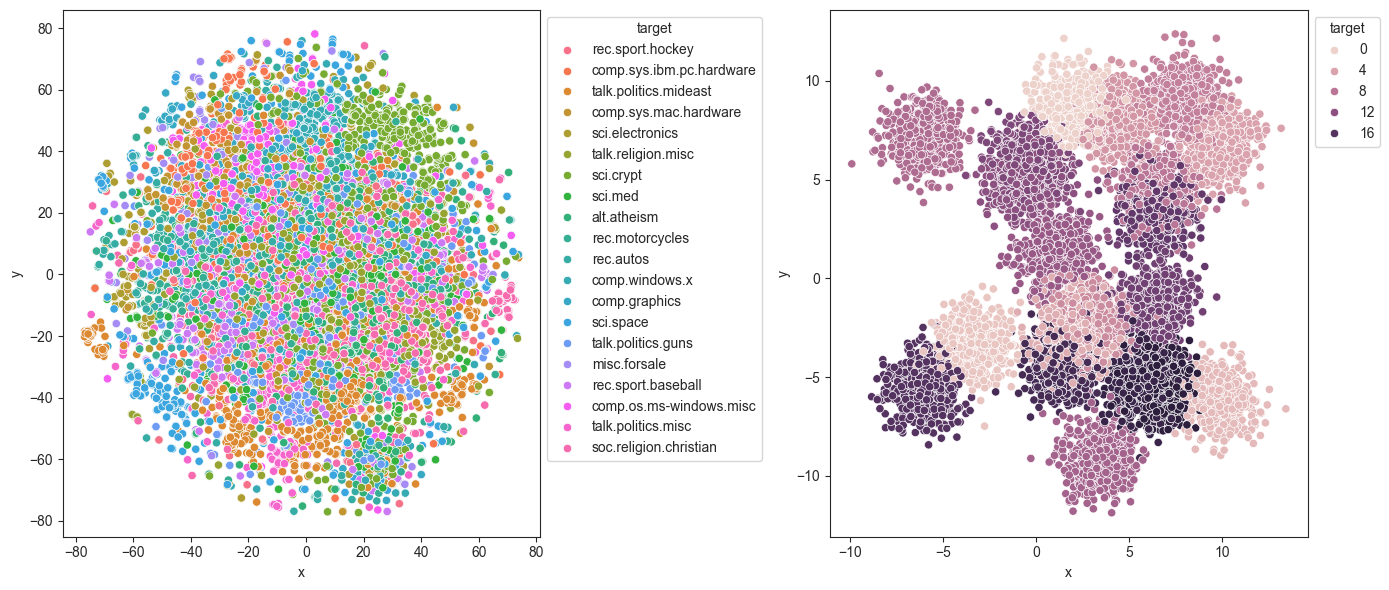

In [79]:
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)
sns.scatterplot(data=D, x="x", y="y", hue="target", ax=ax[0])
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(data=Fd, x="x", y="y", hue="target", ax=ax[1])
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Class boundaries

In [59]:
S = D[(D['target'] == 'talk.politics.mideast') | (D['target'] == 'rec.sport.baseball')]
T = D[(D['target'] == 'rec.sport.hockey') | (D['target'] == 'rec.sport.baseball')]

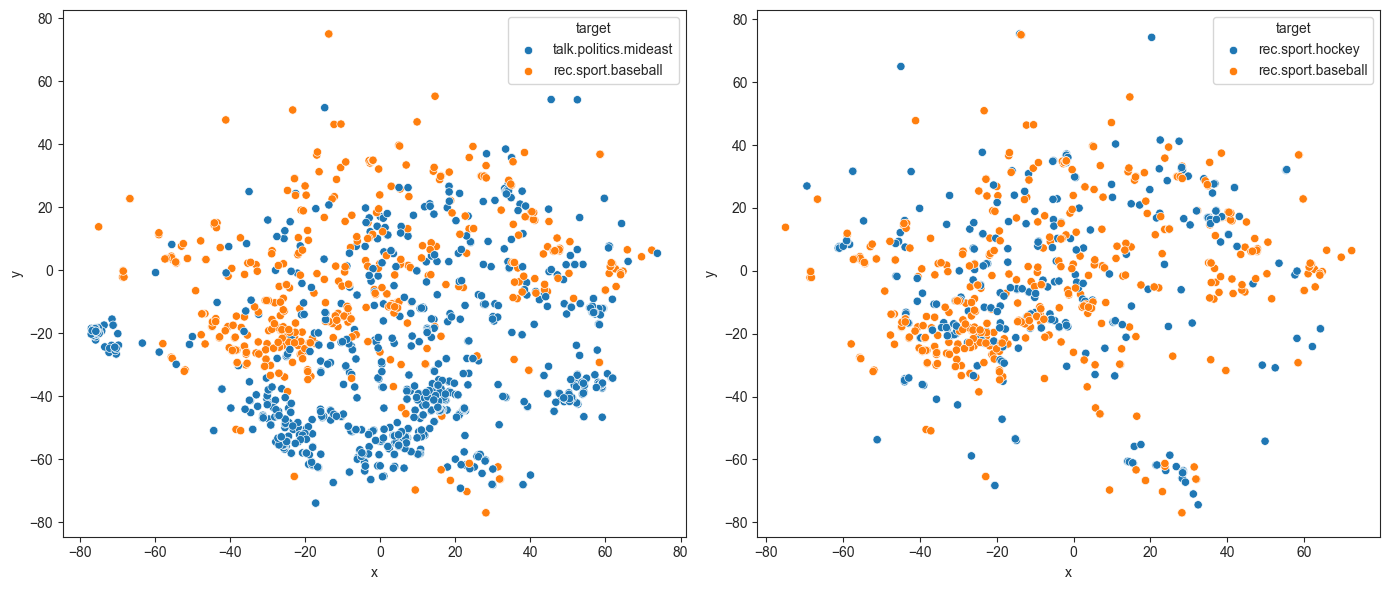

In [82]:
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)
sns.scatterplot(data=S, x="x", y="y", hue="target", ax=ax[0])
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(data=T, x="x", y="y", hue="target", ax=ax[1])
#sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()